**Table of contents**<a id='toc0_'></a>    
- [<b>Load Dataset</b>](#toc1_)    
    - [Load Config Data](#toc1_1_1_)    
    - [Load Dataset](#toc1_1_2_)    
- [<b> Exploratory Data Analysis</b>](#toc2_)    
  - [Profile Report](#toc2_1_)    
  - [Describe Data](#toc2_2_)    
  - [<b> 1. Histogram</b>](#toc2_3_)    
  - [<b>2. Kernel Density Plot</b>](#toc2_4_)    
  - [<b>3. Boxplot of Numeric features</b>](#toc2_5_)    
  - [<b>4.Segment Categorical features by the target classes</b>](#toc2_6_)    
  - [<b>5. Barplot of Categoric Features</b>](#toc2_7_)    
  - [<b>6. Group numeric features by categorical features</b>](#toc2_8_)    
  - [<b>7. Heatmap Correlation</b>](#toc2_9_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
## Load Configuration File

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import src.util as util
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTENC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LassoCV
from xgboost import XGBClassifier

import warnings

warnings.filterwarnings('ignore')


In [2]:
import klib
from ydata_profiling import ProfileReport, compare

In [3]:
sns.set_style('darkgrid')
sns.set(rc = {'axes.facecolor': '#FBFBFB', 'figure.facecolor': '#FBFBFB'})

class clr:
    start = '\033[93m'+'\033[1m'
    bold = '\033[1m'
    underline = '\033[4m'
    color = '\033[93m'
    end = '\033[0m'

# <a id='toc1_'></a>[<b>Load Dataset</b>](#toc0_)

In [4]:
def load_dataset(config_data: dict) -> pd.DataFrame:
    # Load set of data
    x_train = util.pickle_load(config_data["train_set_path"][0])
    y_train = util.pickle_load(config_data["train_set_path"][1])

    x_valid = util.pickle_load(config_data["valid_set_path"][0])
    y_valid = util.pickle_load(config_data["valid_set_path"][1])

    x_test = util.pickle_load(config_data["test_set_path"][0])
    y_test = util.pickle_load(config_data["test_set_path"][1])

    # concatenate x and y each set
    train_set = pd.concat([x_train, y_train], axis = 1)
    valid_set = pd.concat([x_valid, y_valid], axis = 1)
    test_set = pd.concat([x_test, y_test], axis = 1)

    # return 3 set of data
    return train_set, valid_set, test_set

### <a id='toc1_1_1_'></a>[Load Config Data](#toc0_)

In [5]:
config_data = util.load_config()

### <a id='toc1_1_2_'></a>[Load Dataset](#toc0_)

In [6]:
train_set, valid_set, test_set = load_dataset(config_data)

# <a id='toc2_'></a>[<b> Exploratory Data Analysis</b>](#toc0_)

-----

## <a id='toc2_1_'></a>[Profile Report](#toc0_)

In [7]:
train_set_report = ProfileReport(train_set, progress_bar=False, title="train_set", explorative=True, sample=None)

train_set_report.to_file("data_profile_report.html")

## <a id='toc2_2_'></a>[Describe Data](#toc0_)

In [85]:
train_set.describe().style.background_gradient(cmap='YlOrBr')

,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
count,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000,800.000000
mean,204.001250,39.016250,544664.695000,1257.717500,502376.073750,24541.625000,-26499.875000,11.568750,52173.800000,7373.562500,7324.225000,37476.012500
std,114.308954,9.111243,257844.798758,241.703239,72297.680525,27683.000479,27953.002977,6.903974,27072.205473,4947.459386,4890.629967,19309.207955
min,0.000000,20.000000,100804.000000,433.000000,430104.000000,0.000000,-111100.000000,0.000000,1920.000000,0.000000,0.000000,1440.000000
25%,115.750000,32.000000,330473.000000,1097.000000,448692.250000,0.000000,-51025.000000,6.000000,39950.000000,4065.000000,4270.000000,28980.000000
50%,202.000000,38.500000,533940.500000,1265.000000,466704.500000,0.000000,-21200.000000,12.000000,57700.000000,6675.000000,6700.000000,41760.000000
75%,276.000000,44.250000,757918.000000,1406.000000,603417.500000,50400.000000,0.000000,17.000000,70425.000000,11330.000000,10940.000000,50762.500000
max,479.000000,64.000000,999435.000000,2047.000000,620962.000000,100500.000000,0.000000,23.000000,114920.000000,21450.000000,23670.000000,79560.000000


In [88]:
train_set.describe(include='object')

,policy_deductable,umbrella_limit,number_of_vehicles_involved,bodily_injuries,witnesses,auto_year,policy_state,policy_csl,insured_sex,insured_hobbies,...,collision_type,incident_severity,authorities_contacted,incident_state,incident_city,property_damage,police_report_available,auto_make,auto_model,fraud_reported
count,800,800,800,800,800,800,800,800,800,800,...,800,800,800,800,800,800,800,800,800,800
unique,3,11,4,3,4,21,3,3,2,20,...,4,4,5,7,7,3,3,14,39,2
top,500,0,1,0,1,2003,OH,250/500,FEMALE,reading,...,Rear Collision,Minor Damage,Police,NY,Springfield,UNKNOWN,NO,Suburu,Wrangler,N
freq,277,639,466,276,208,48,282,286,426,54,...,232,281,235,205,127,286,278,70,33,602


## <a id='toc2_3_'></a>[<b> 1. Histogram</b>](#toc0_)

What we look out for:
- Potential <b>outliers</b>
- <b>Numeric features that should be categorical (indicator)</b> features. For example, if there are only two possible values like 0 and 1.
- Boundaries that do not make sense, such as <b>percentage value more than 100</b>.

Using the `histplot` from seaborn with `kind = kde`, and separate the histogram into two category of target. <br>
Histogram are using to approach the miscellaneous thing we seek before, while `kde` are using to understand the distribution of the numeric features.

<Figure size 1000x1000 with 0 Axes>

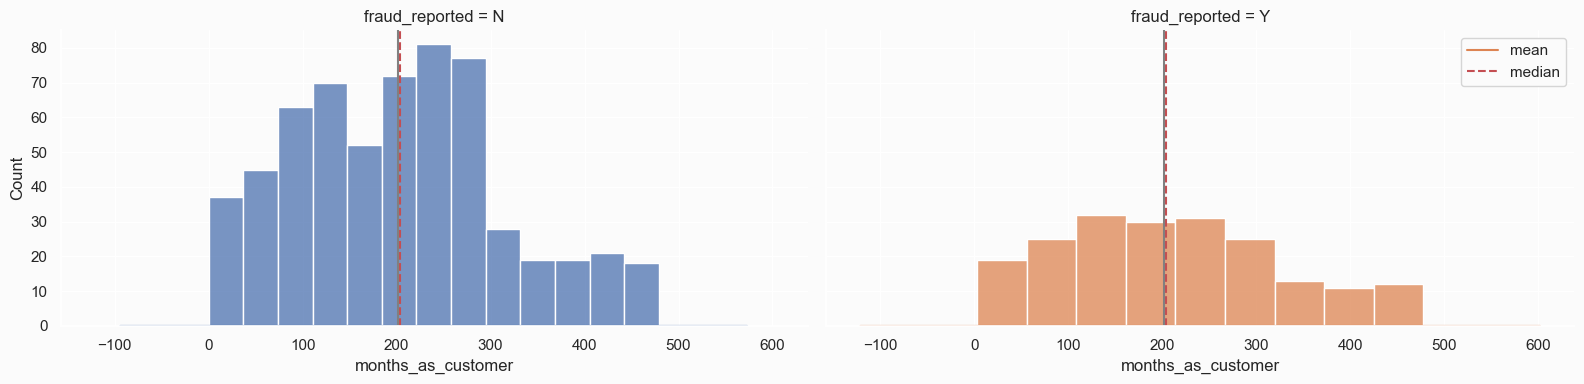

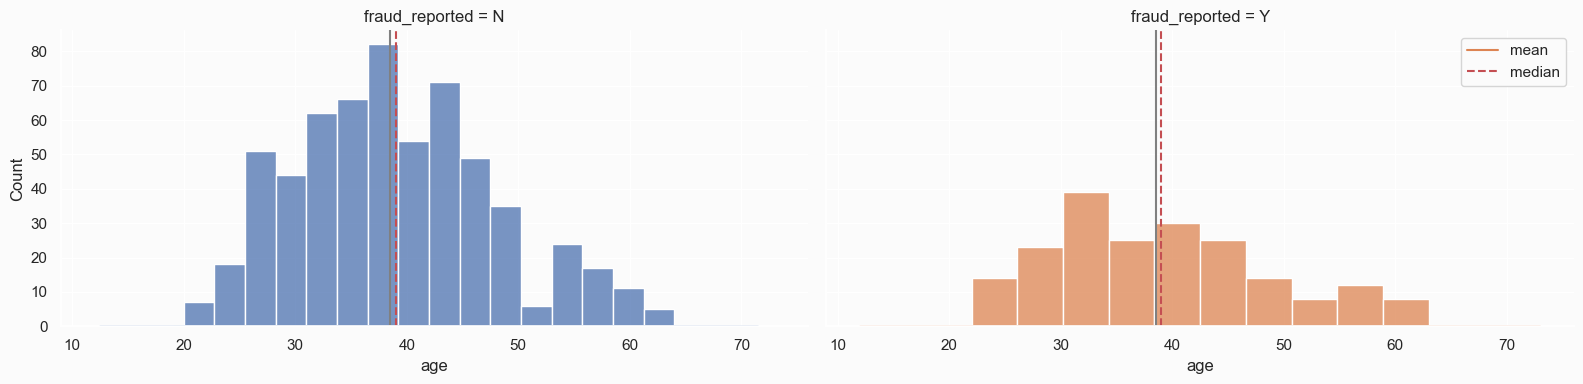

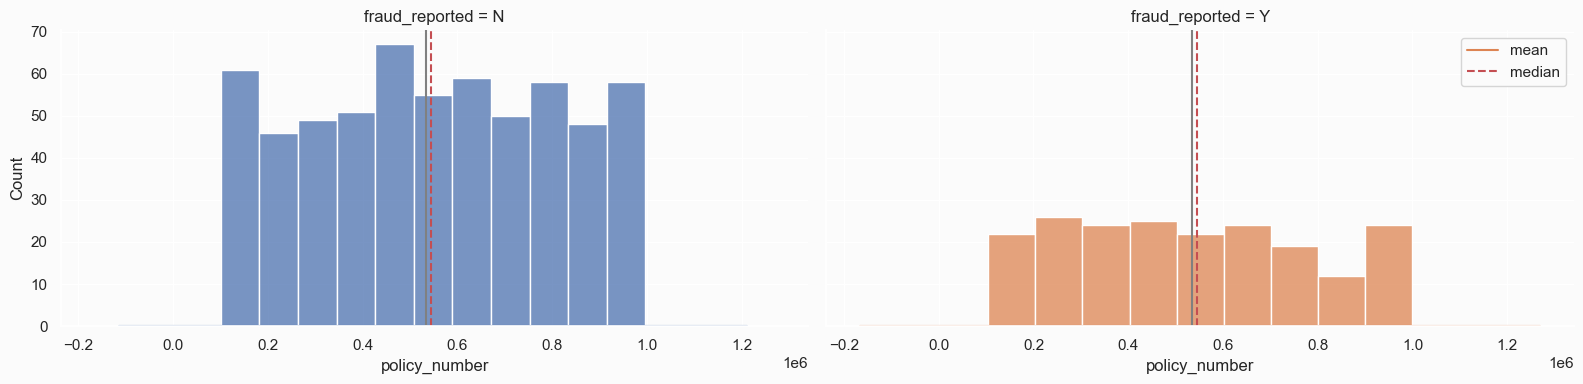

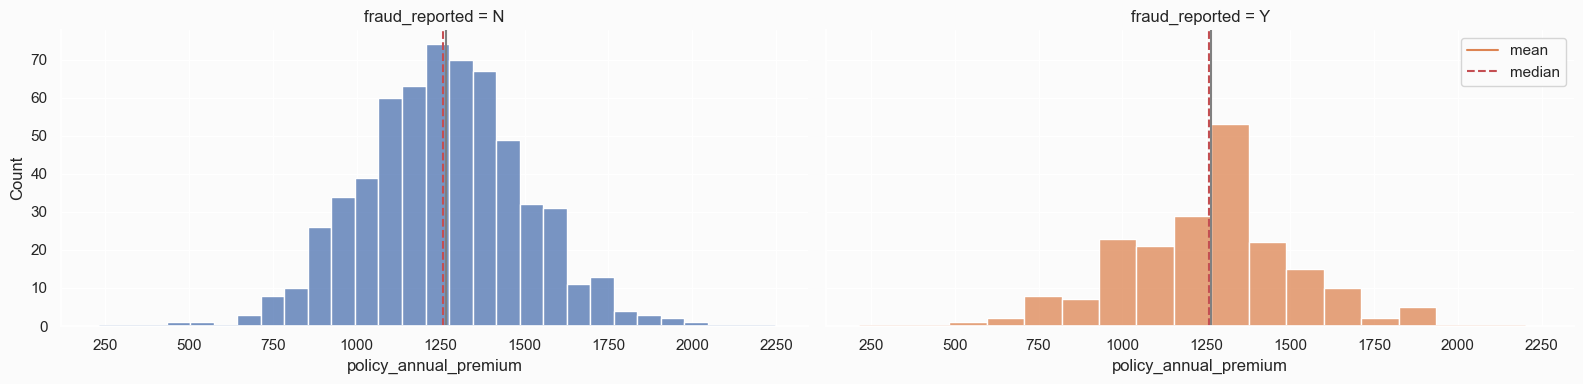

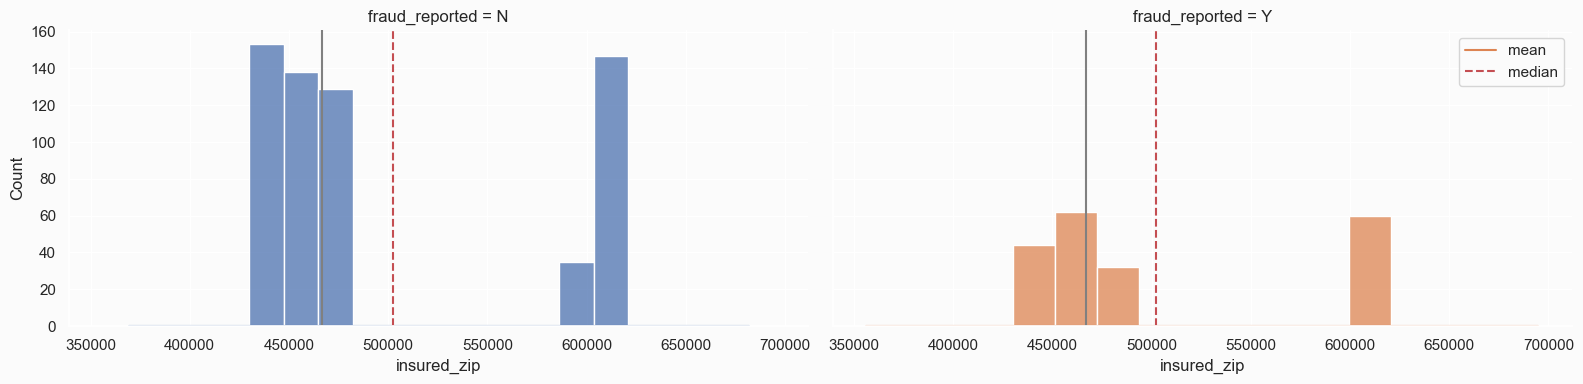

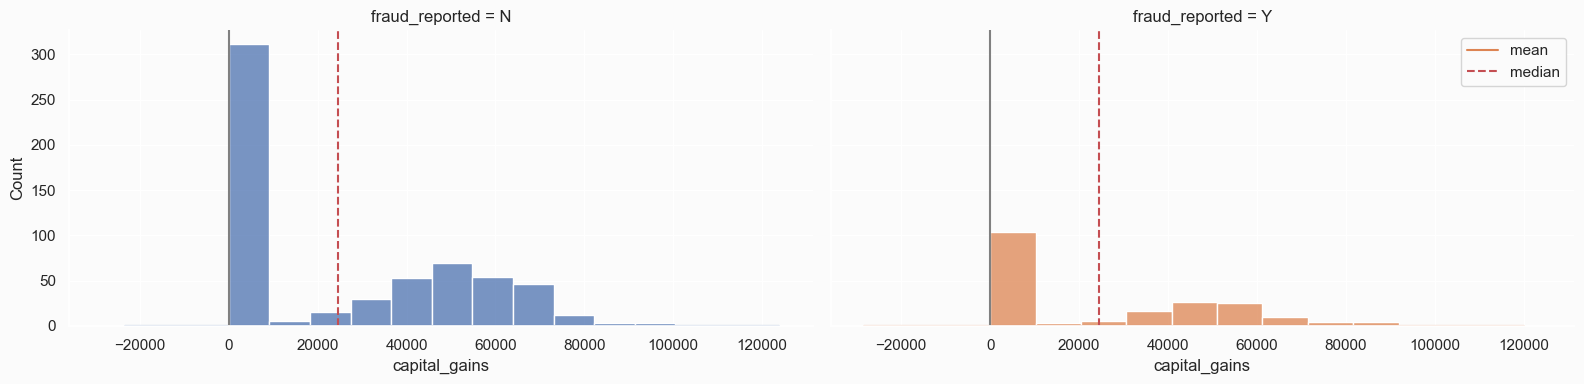

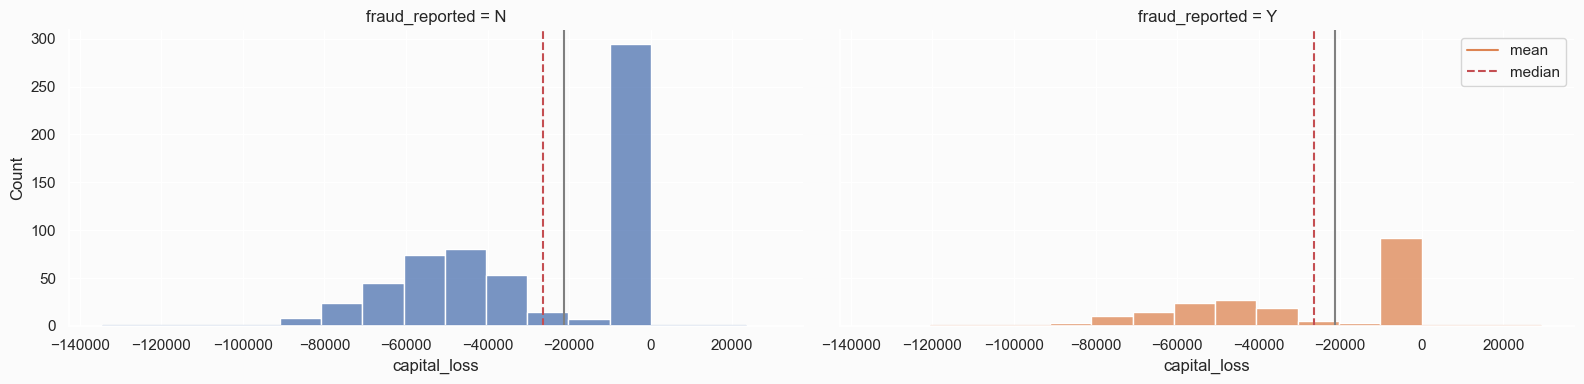

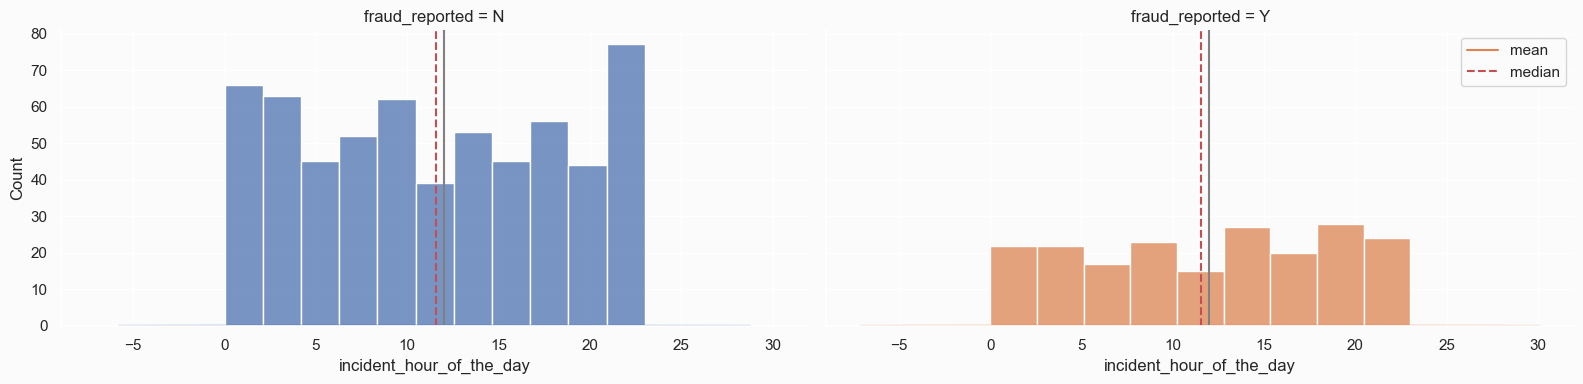

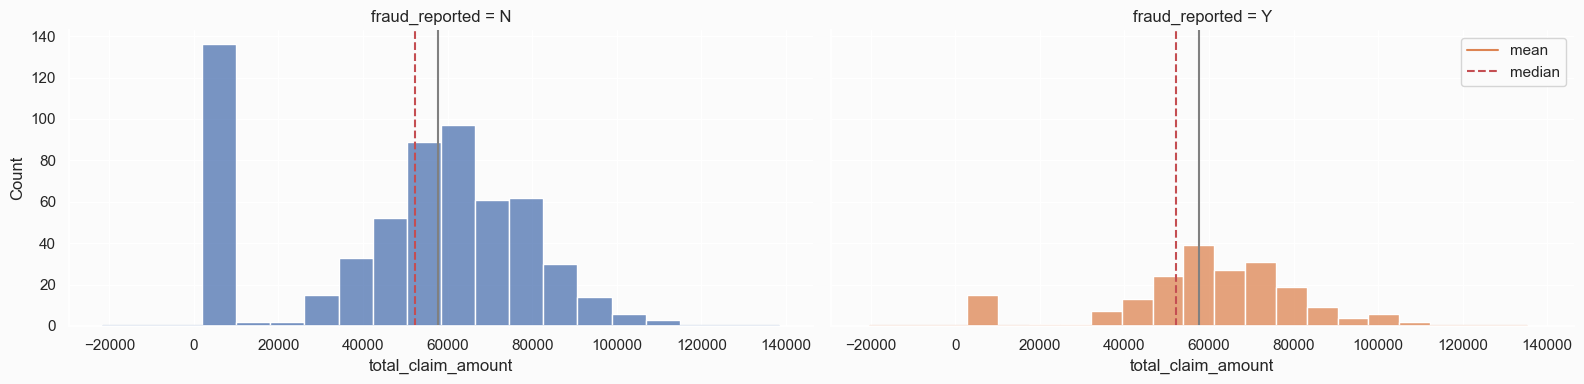

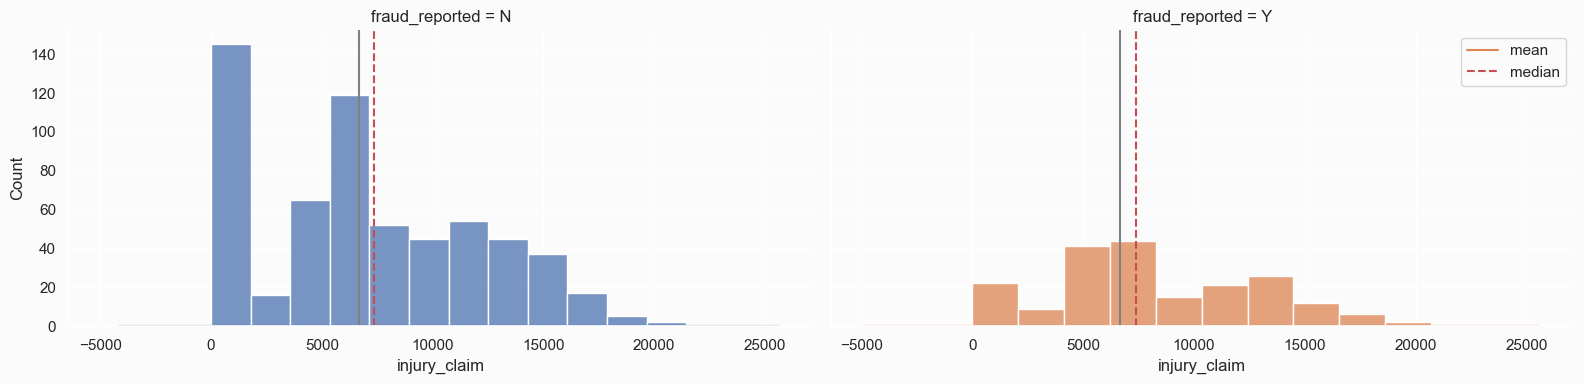

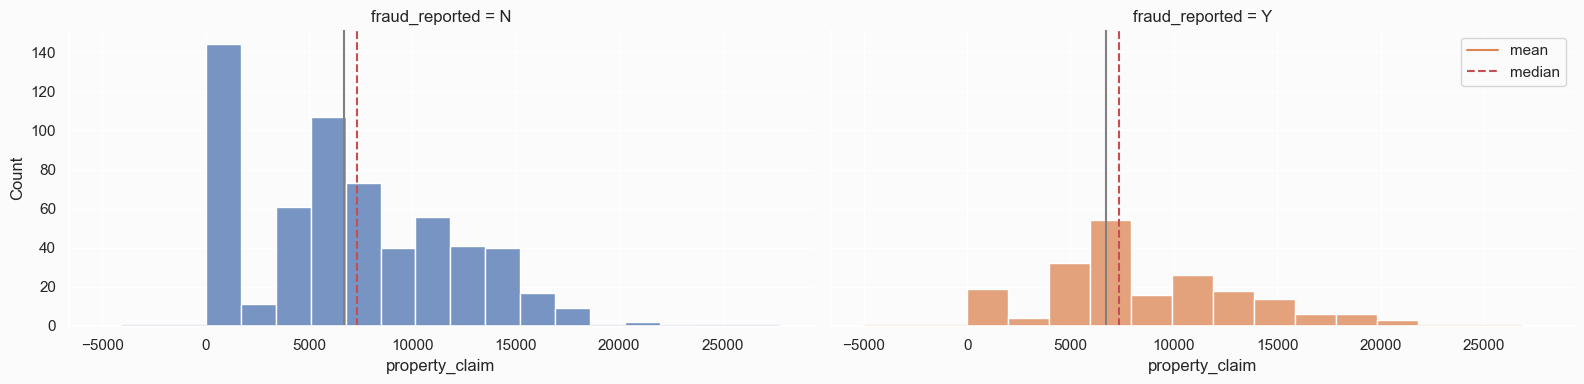

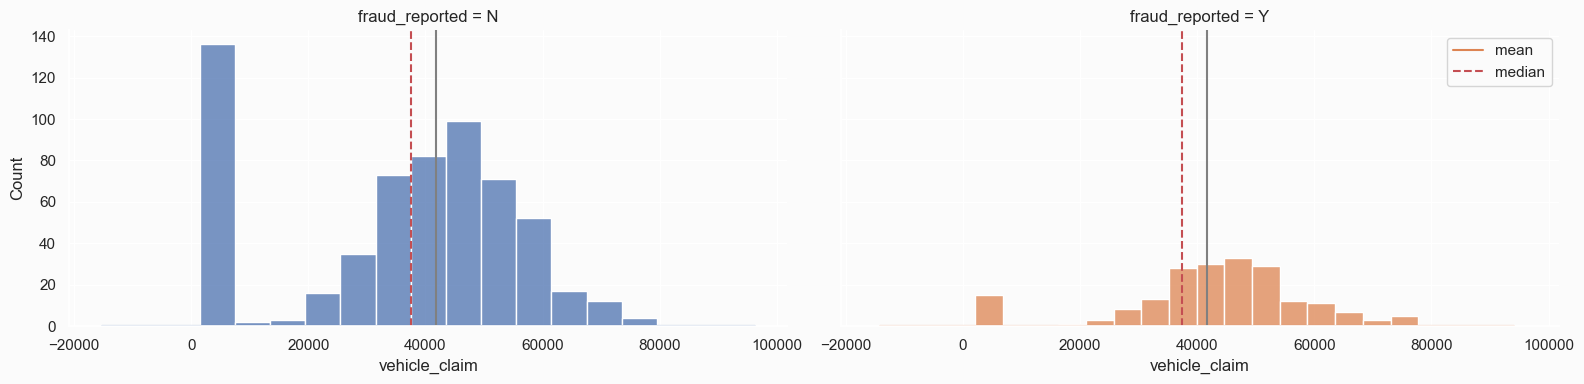

In [35]:
list_num_col = []

for col in train_set.columns:
    if (train_set[col].dtype =='int32'):
        list_num_col.append(col)

plt.figure(figsize=(10,10))
count = 0

for i in range(len(list_num_col) // 2):
    for j in range(2):

        if count >= len(list_num_col):
            break

        g = sns.FacetGrid(data=train_set, col='fraud_reported', hue='fraud_reported', height=4, aspect= 2)
        g.map_dataframe(sns.histplot, x=list_num_col[count])
        g.map_dataframe(sns.kdeplot, x=list_num_col[count])
        
        g.refline(x=train_set[list_num_col[count]].mean(), color='r')
        g.refline(x=train_set[list_num_col[count]].median(), linestyle='-')

        plt.legend(['mean', 'median'])

        count += 1

plt.tight_layout()
plt.show()

- <b>`insured_zip`</b> are prone into two group of <b>>500.000</b> and <b><600.000</b>
- <b>`capital_gains`</b> is highly <b>left-skewed</b> distributed since it has much zero values (0)

## <a id='toc2_4_'></a>[<b>2. Kernel Density Plot</b>](#toc0_)

KDE plot using `klib.dist_plot` to give better distribution comprehension of numeric features, given <b>mean, median, and standard deviation</b>

<Axes: xlabel='vehicle_claim', ylabel='Density'>

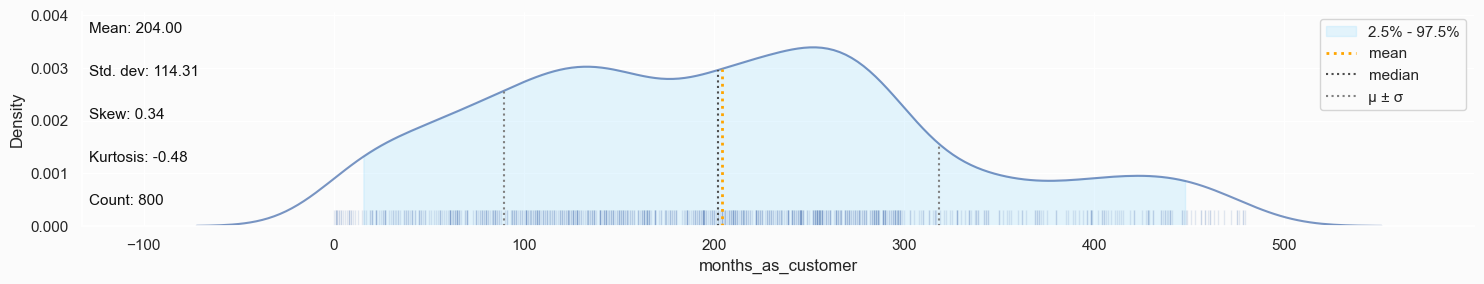

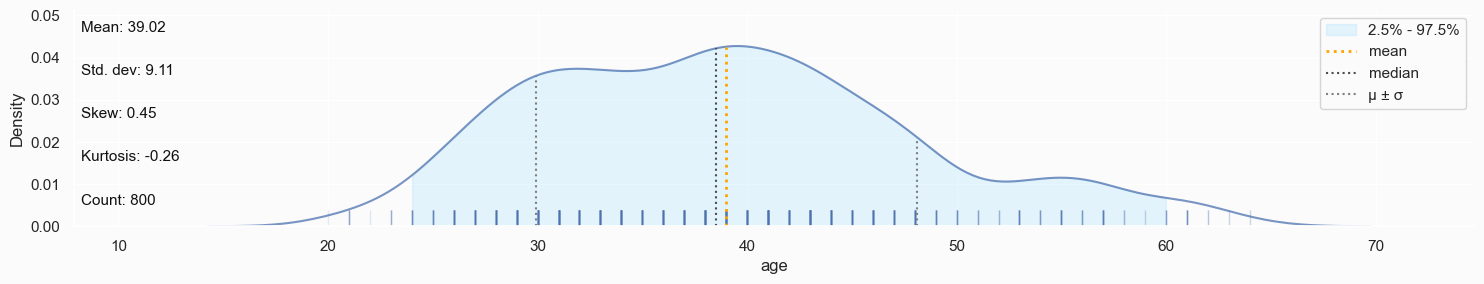

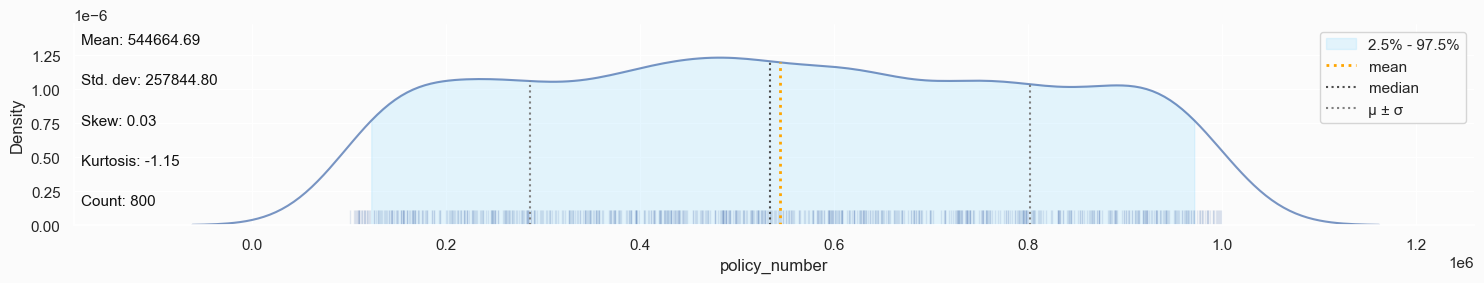

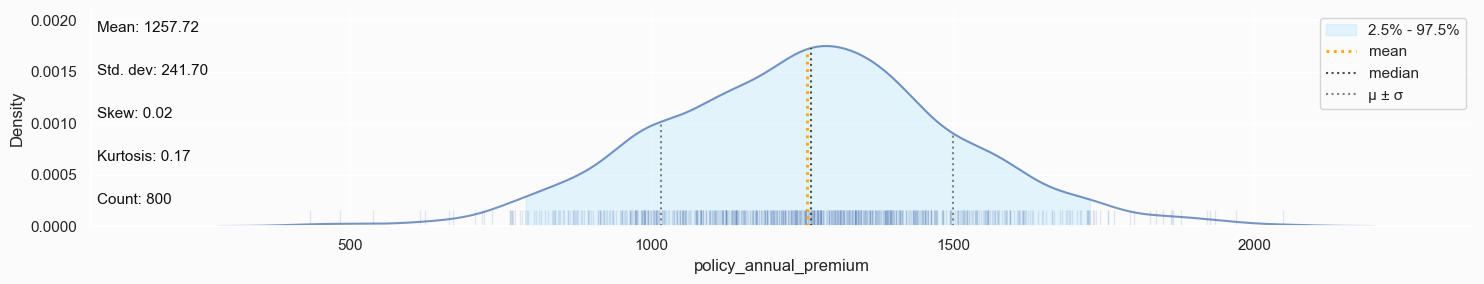

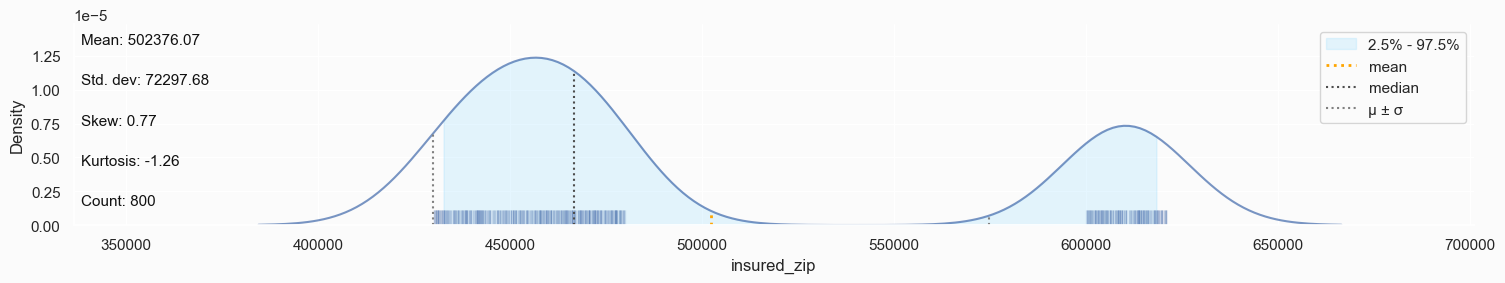

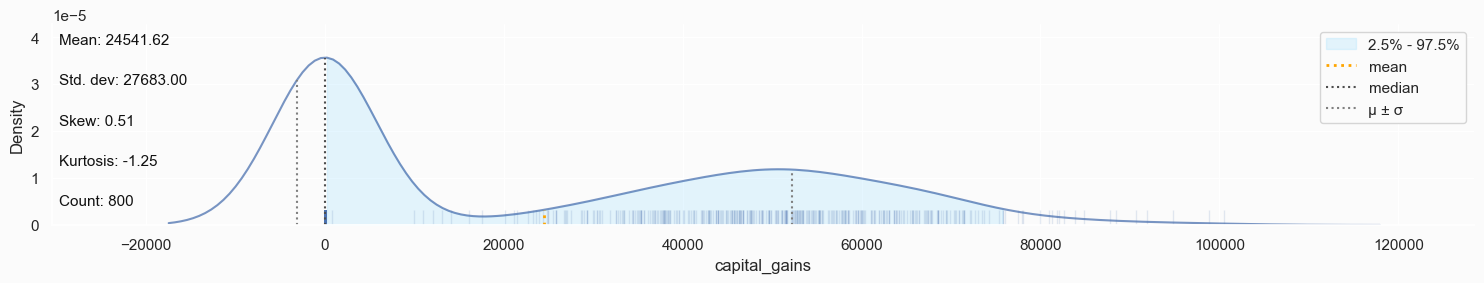

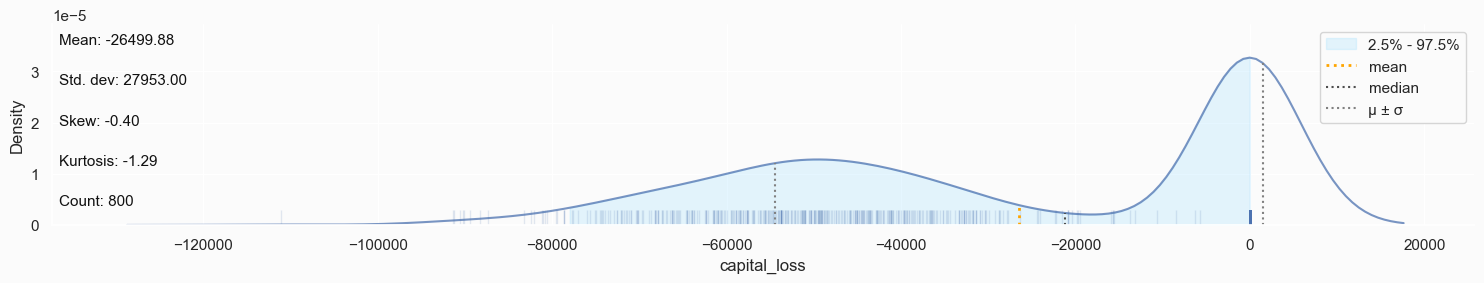

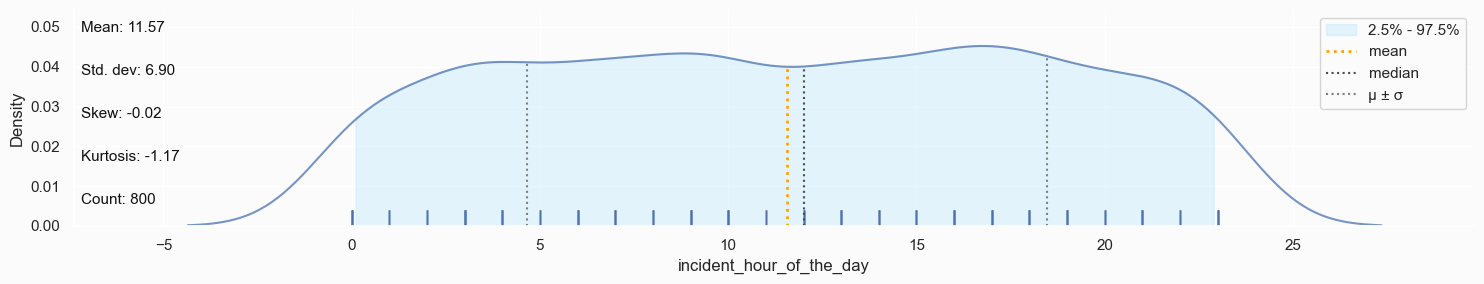

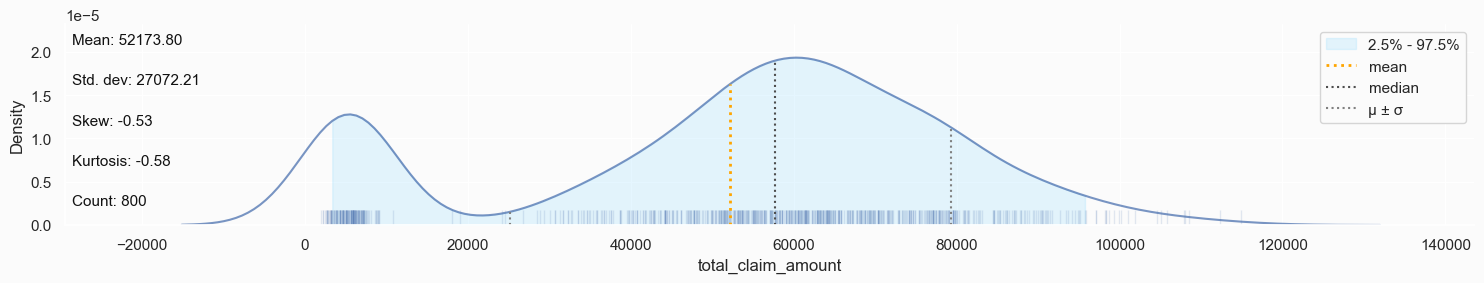

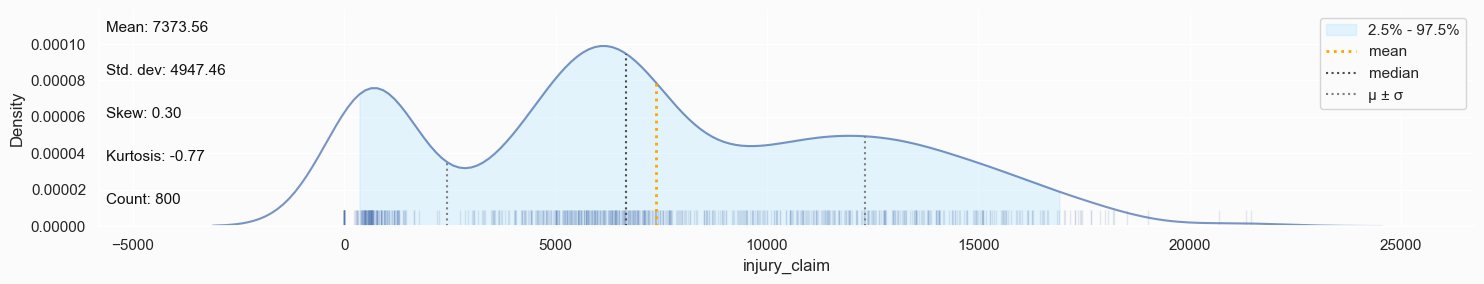

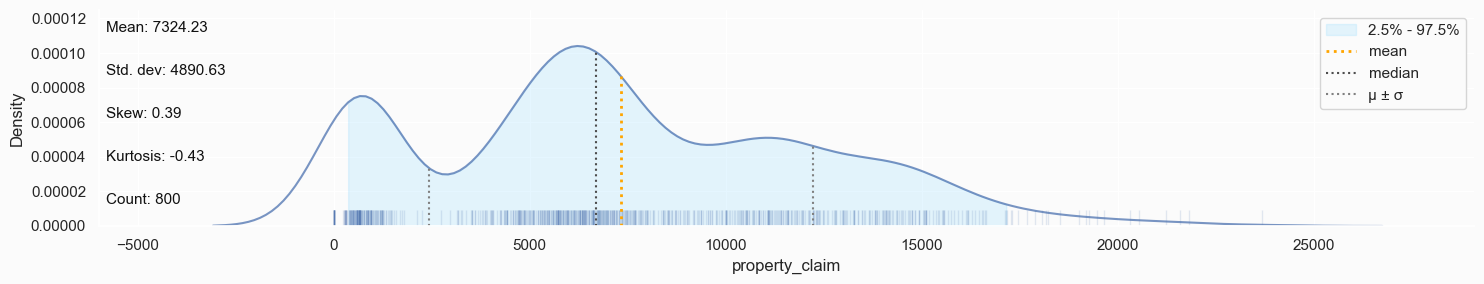

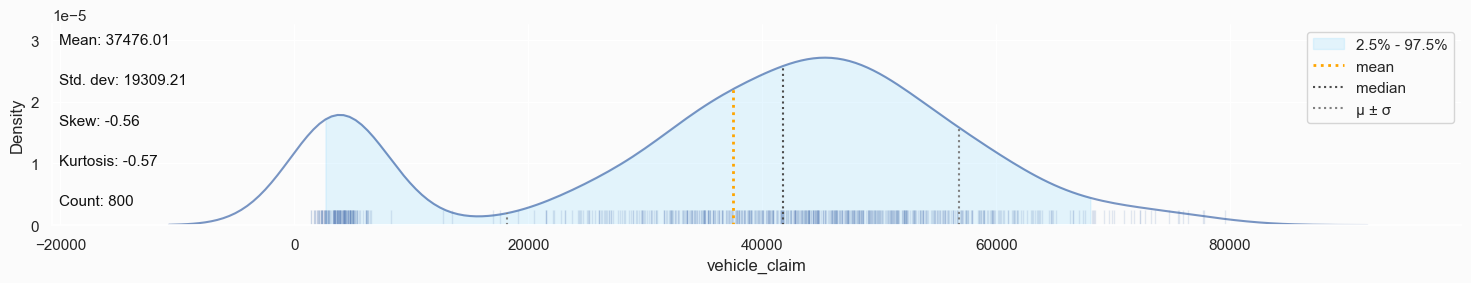

In [30]:
klib.dist_plot(train_set)

There are several features in the dataset that exhibit a **`bimodal distribution`**, meaning they have two distinct peaks or modes. These features are strongly **correlated with the amount of money**. Consequently, the **occurrence of a value of 0 in these features creates the bimodal distribution**. The correlation with the amount of money suggests that these features play a significant role in determining the monetary values observed in the dataset.

## <a id='toc2_5_'></a>[<b>3. Boxplot of Numeric features</b>](#toc0_)

**Segment the target by numeric features**

<center>
<img src='https://th.bing.com/th/id/OIP.0MPDTLn8KoLApoFvI0P2vQHaDt?pid=ImgDet&rs=1'>
</center>

We will use **`sns.boxplot`** which displays the five-number summary of a numeric feature. The five numbers are **minimum**, **first quartile (Q1 or 25% mark)**,**median (Q2)**, **third quartile (Q3 or 75% mark)**, and **maximum**

Here, we will separate the data by the target feature and observe how the numeric features are distributed among those which **fraud (target = 1)** and those which **non-fraud (target = 0)**.



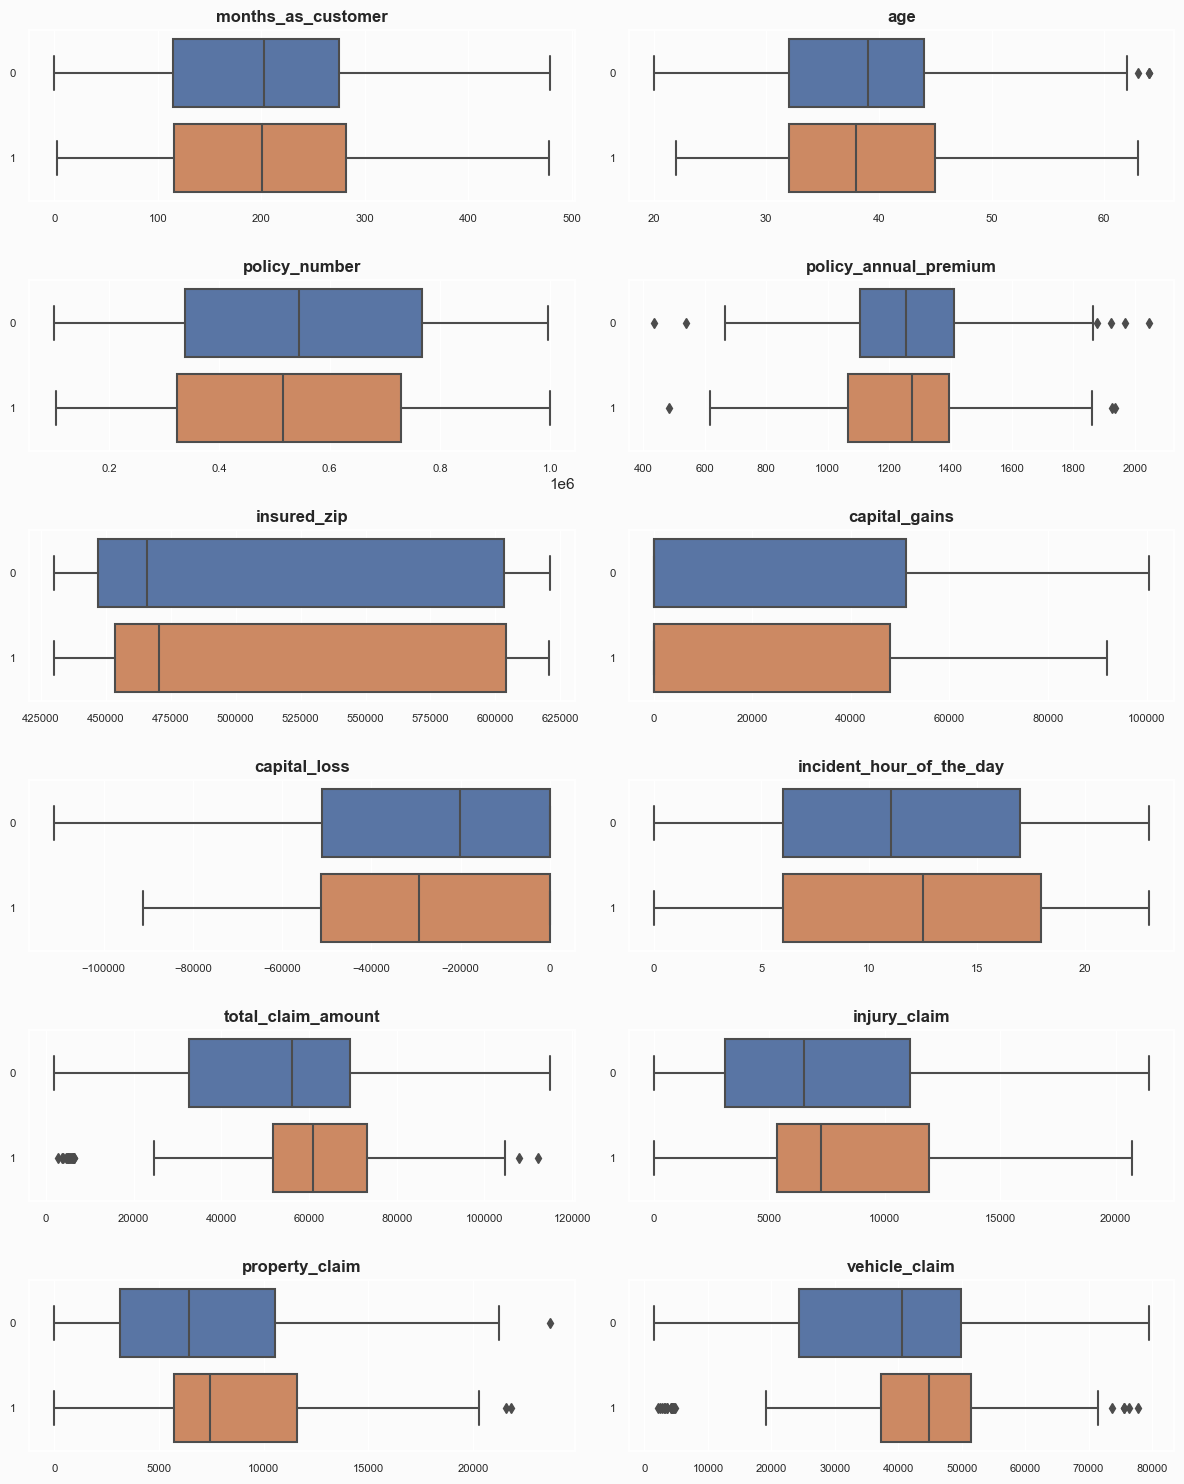

In [ ]:
fig, axs = plt.subplots(len(list_num_col) // 2, 2, figsize=(12,15))
count = 0

train_set_box = train_set.copy()
train_set_box.fraud_reported = train_set_box.fraud_reported.map(dict(Y=1,N=0))


for i in range(len(list_num_col) // 2):
    for j in range(2):

        if count >= len(list_num_col):
            break

        sns.boxplot(data = train_set_box, x=list_num_col[count], y='fraud_reported', ax=axs[i, j], orient='h')

        axs[i, j].tick_params(axis='x', labelsize=8)
        axs[i, j].tick_params(axis='y', labelsize=8)

        axs[i, j].set_xlabel('')
        axs[i, j].set_ylabel('')
        axs[i, j].set_title(list_num_col[count], fontweight='bold')
        # axs[i, j].legend(loc='upper right')

        count += 1

# fig.legend(['N','Y'], loc='upper right', title='fraud_reported')

plt.tight_layout()
plt.show()

We can see that **`month_as_customers, age, insured_zip, capital_gains, capital_loss, incident_hours_of_the_day`** <br>
are almost **equally distributed** among those which non-fraud (target 0) and those which fraud (target 1). <br>
This means that training_hours **might not be a good predictor** for the target. 

However, we see that when it comes to **`policy_annual_premium, total_claim_amount, injury_claim, property_claim, vehicle_claim`**,<br> 
a bigger proportion of those who stayed are tending towards more years of experience and these could be **good predictors**.

## <a id='toc2_6_'></a>[<b>4.Segment Categorical features by the target classes</b>](#toc0_)

Now that we have seen how the target changes with numeric features, we will do the same for categorical features.

**`pd.crosstab(col1, col2)`** function builds a *cross-tabulation table* that shows the **relationship between two categorical features**. The table shows the **frequency** by which groups of data from the two features appear. You can include the parameter `normalize='index'` to show the percentages

Here, loop through 4 categorical columns (those with less than 5 unique classes).

In [101]:
for col in list_cat_col:
    if train_set[col].nunique() <= 4:
        display(pd.crosstab(train_set.fraud_reported, train_set[col], normalize='index').style.background_gradient(cmap='YlOrBr'))

policy_deductable,1000,2000,500
fraud_reported,,,
N,0.342193,0.312292,0.345515
Y,0.313131,0.338384,0.348485


number_of_vehicles_involved,1,2,3,4
fraud_reported,,,,
N,0.594684,0.026578,0.350498,0.028239
Y,0.545455,0.035354,0.378788,0.040404


bodily_injuries,0,1,2
fraud_reported,,,
N,0.353821,0.323920,0.322259
Y,0.318182,0.287879,0.393939


witnesses,0,1,2,3
fraud_reported,,,,
N,0.262458,0.260797,0.237542,0.239203
Y,0.191919,0.257576,0.308081,0.242424


policy_state,IL,IN,OH
fraud_reported,,,
N,0.335548,0.317276,0.347176
Y,0.318182,0.313131,0.368687


policy_csl,100/300,250/500,500/1000
fraud_reported,,,
N,0.335548,0.358804,0.305648
Y,0.363636,0.353535,0.282828


insured_sex,FEMALE,MALE
fraud_reported,,
N,0.533223,0.466777
Y,0.530303,0.469697


incident_type,Multi-vehicle Collision,Parked Car,Single Vehicle Collision,Vehicle Theft
fraud_reported,,,,
N,0.405316,0.114618,0.367110,0.112957
Y,0.454545,0.040404,0.469697,0.035354


collision_type,Front Collision,Rear Collision,Side Collision,UNKNOWN
fraud_reported,,,,
N,0.244186,0.270764,0.257475,0.227575
Y,0.287879,0.348485,0.287879,0.075758


incident_severity,Major Damage,Minor Damage,Total Loss,Trivial Damage
fraud_reported,,,,
N,0.146179,0.420266,0.318937,0.114618
Y,0.661616,0.141414,0.166667,0.030303


property_damage,NO,UNKNOWN,YES
fraud_reported,,,
N,0.378738,0.338870,0.282392
Y,0.272727,0.414141,0.313131


police_report_available,NO,UNKNOWN,YES
fraud_reported,,,
N,0.340532,0.330565,0.328904
Y,0.368687,0.348485,0.282828


fraud_reported,N,Y
fraud_reported,,
N,1.000000,0.000000
Y,0.000000,1.000000


These tables show few categoric features do not have significant difference between target of **fraud (Y)** and **non-fraud (N)** such as:<br>
**`policy_deductable, policy_state, police_report_available, insured_sex, policy_csl, policy_state`**

## <a id='toc2_7_'></a>[<b>5. Barplot of Categoric Features</b>](#toc0_)

Here, we gonna visualize the **pd.crosstab** above into `countplot`

We can plot the categorical relationships above to get a better feel of the interactions. <br>
We will create count plots of the data using **Seaborn’s `catplot()`** function and provide **`kind=count`** as a parameter

Notice the parameter **`sharey=False`** in catplot which disassociates the y-scales for each target class so that we can **better view and compare the relationships**.

<Figure size 1200x300 with 0 Axes>

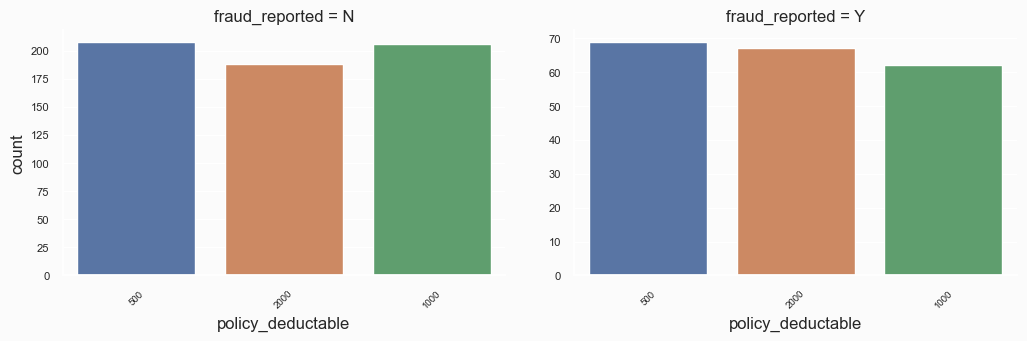

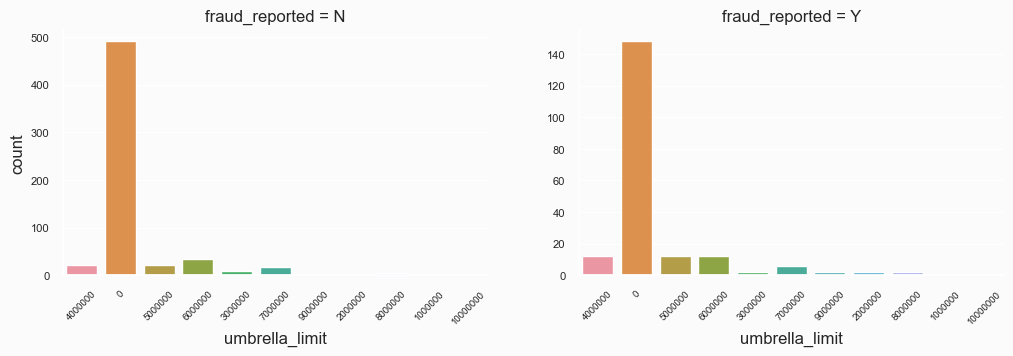

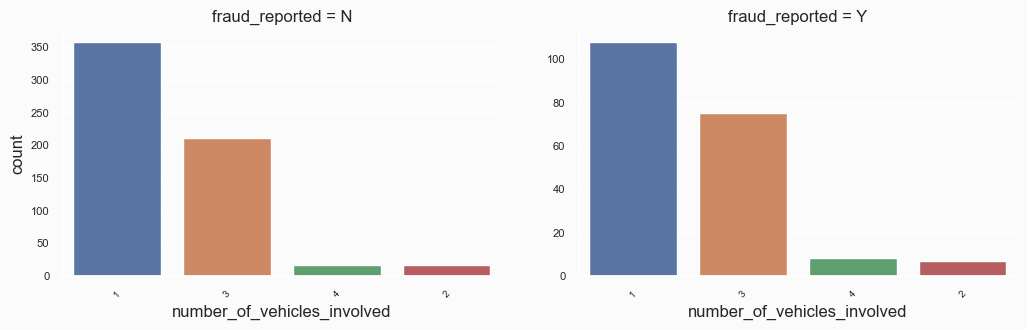

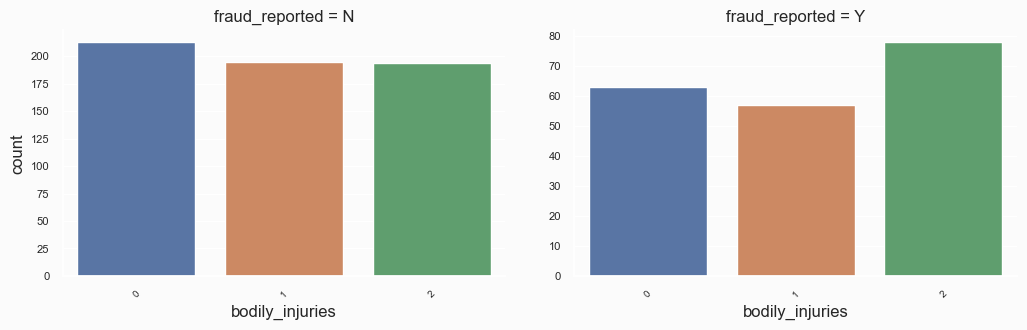

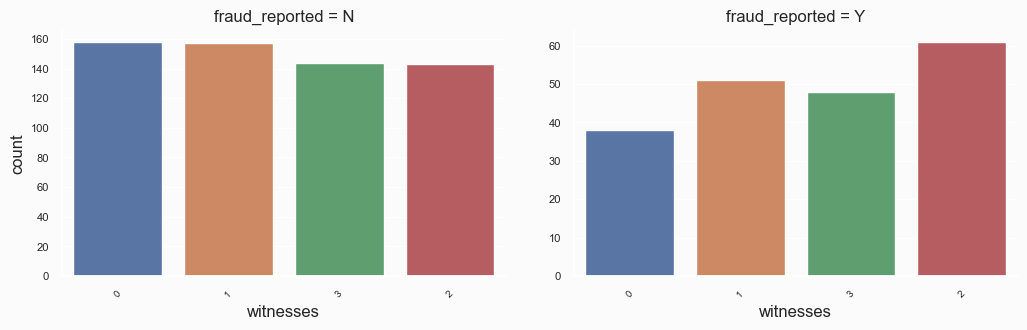

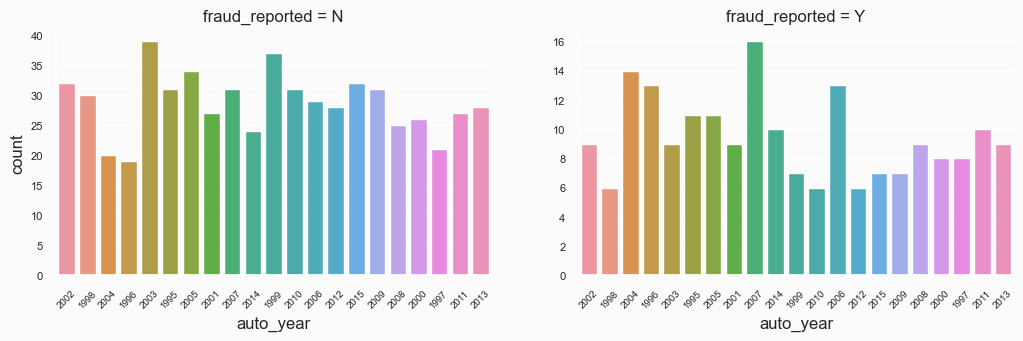

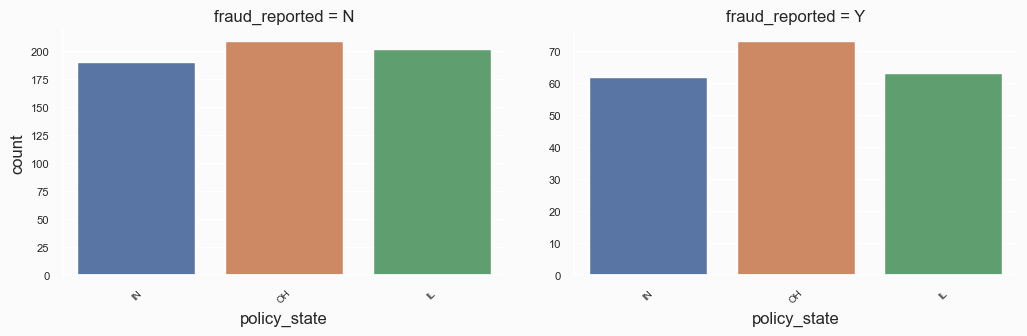

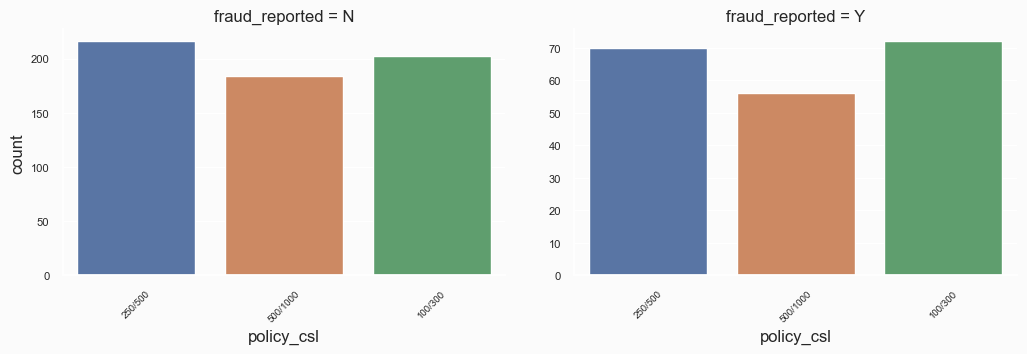

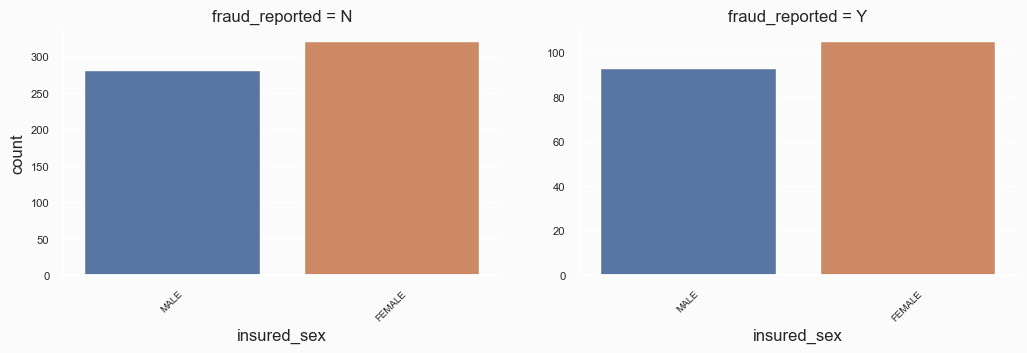

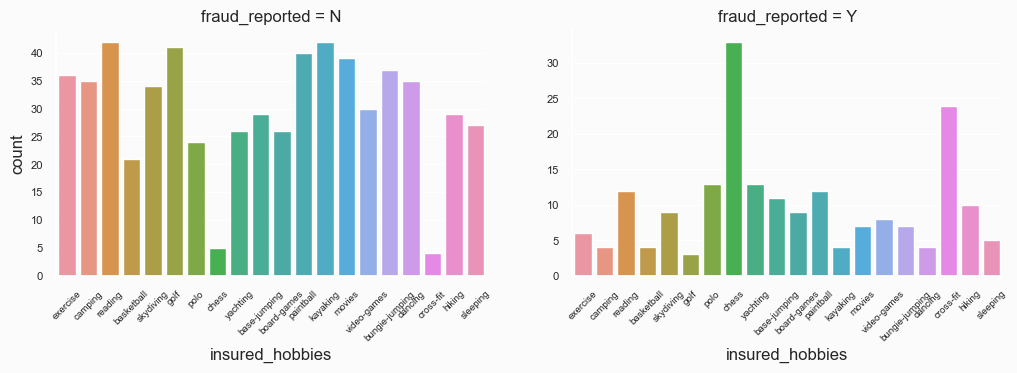

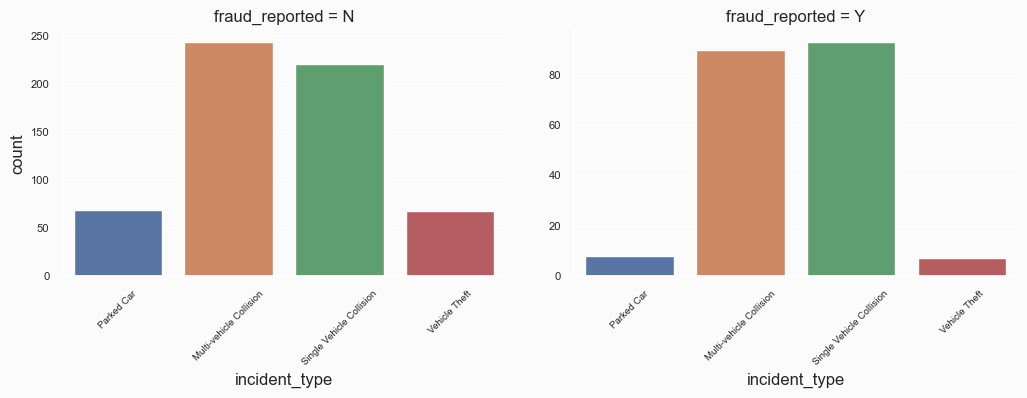

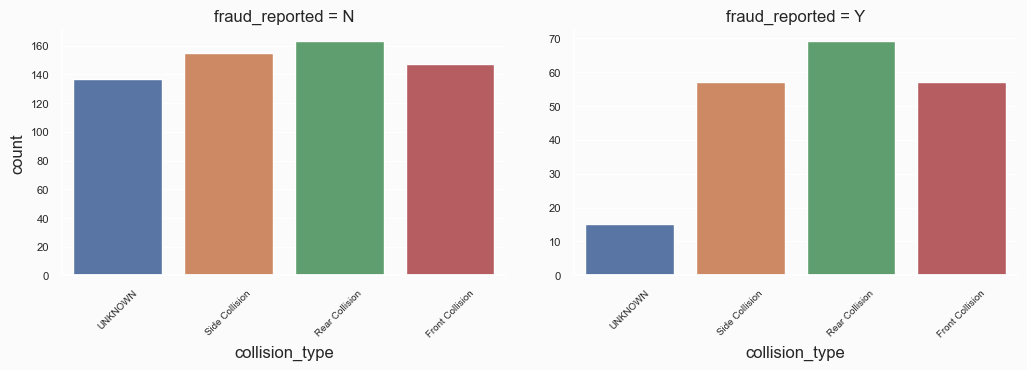

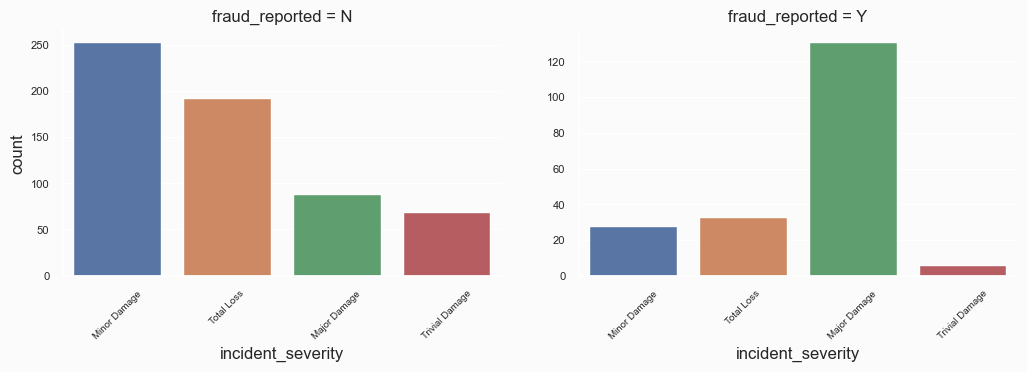

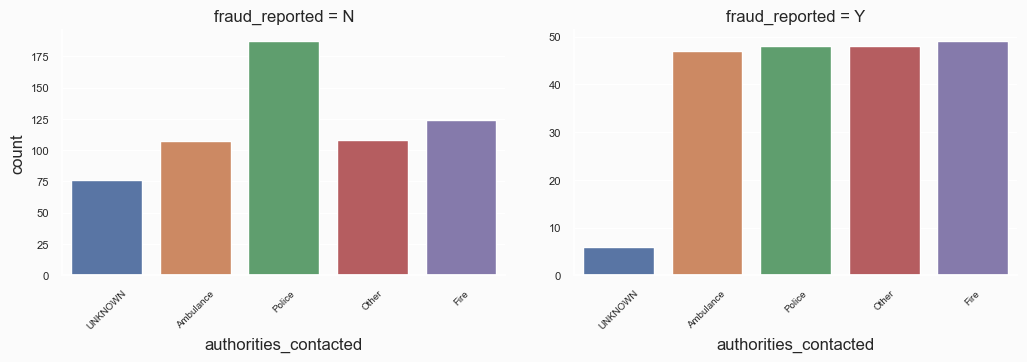

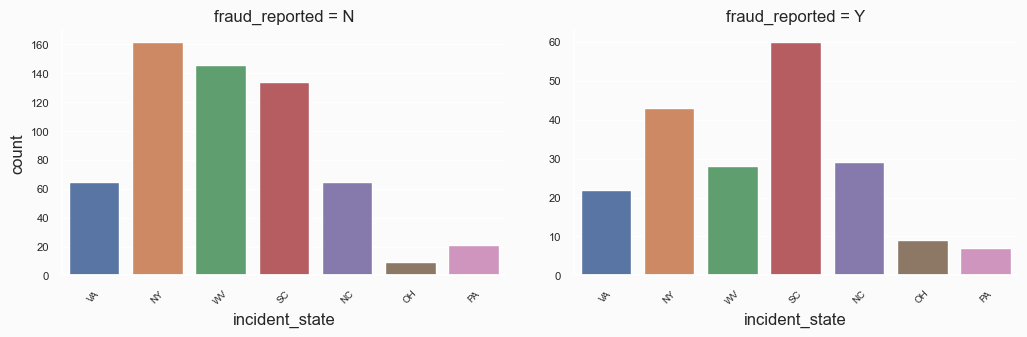

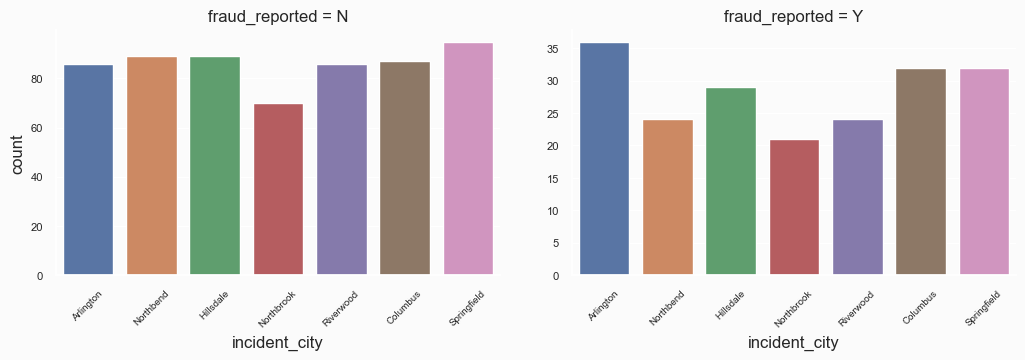

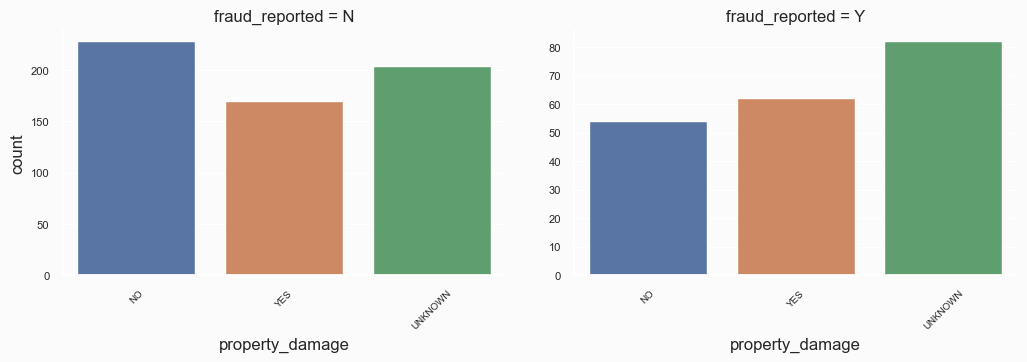

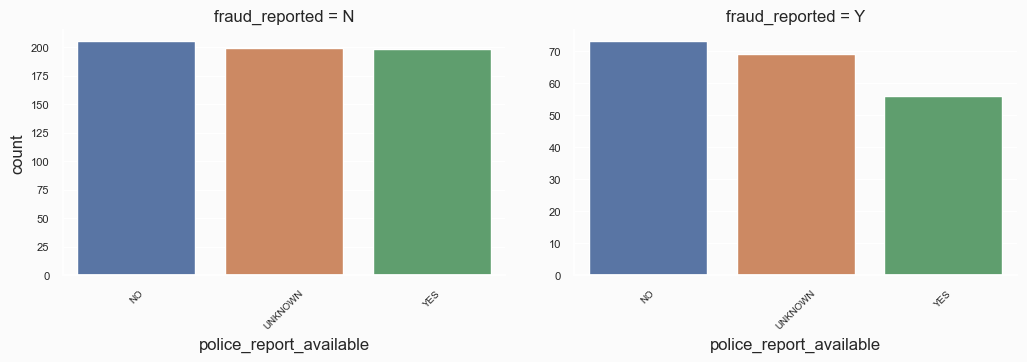

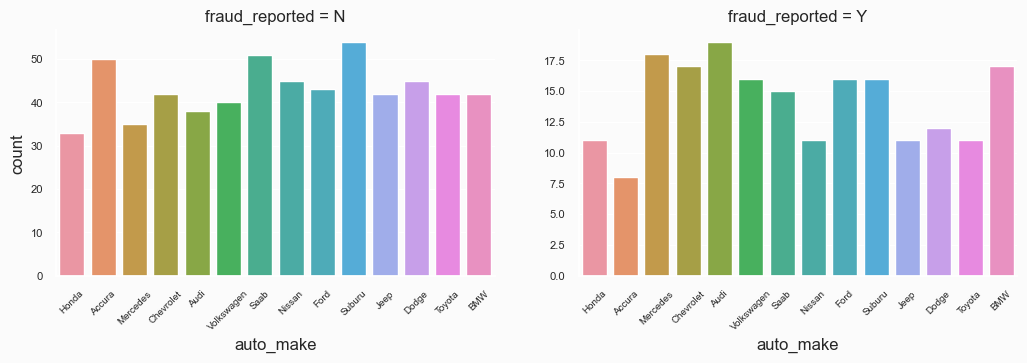

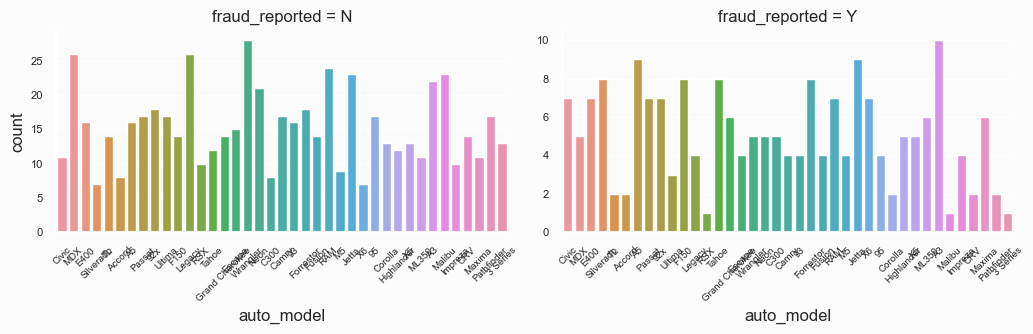

In [ ]:
list_cat_col = []

for col in train_set.columns:
    if (train_set[col].dtype =='object'):
        list_cat_col.append(col)

plt.figure(figsize=(12, 3))
count = 0

for i in range(len(list_cat_col) // 2):
    for j in range(2):

        if count >= len(list_cat_col):
            break

        c = sns.catplot(data = train_set, x = list_cat_col[count], col='fraud_reported', kind='count', 
                        sharey=False, height=3.5, aspect=1.5)

        c.tick_params(axis='x', labelsize=8)
        c.tick_params(axis='y', labelsize=8)
        c.set_xticklabels(rotation=45, fontsize=7)

        count += 1

plt.tight_layout()
plt.show()

**`property_damage`, `bodily_injuries`, `witnesses`, `insured_hobbies`, `collision_type`, `incident_severity`, `authorities_contacted`, <br>
`incident_state`, `incident_city`, `property_damage`, `auto_make`, `auto_model`**

These features show a **significant relationship between target (fraud_reported)**. <br>
Visibly, they **exhibit distinct patterns that are different from each other**. These patterns in the features are strongly associated with the occurrence of fraud, making them crucial indicators for predicting fraudulent activities.

## <a id='toc2_8_'></a>[<b>6. Group numeric features by categorical features</b>](#toc0_)

We will use the **`pd.groupby()`** function to group our data into categories and observe how the numeric features are distributed by calculating a metric such as 

**`mean, median, and standard deviation`** across the classes.

In [117]:
for col in list_cat_col:
    if train_set[col].nunique() <= 5:
        display(train_set.groupby(col)[list_num_col].mean().style.background_gradient(cmap='Blues'))

,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
policy_deductable,,,,,,,,,,,,
1000,195.858209,38.477612,535343.317164,1272.660448,496124.138060,22939.552239,-26857.089552,11.768657,50640.037313,7035.261194,6780.634328,36824.141791
2000,208.486275,39.364706,549448.584314,1255.117647,504233.329412,27021.568627,-27859.607843,12.266667,53835.098039,7661.372549,7850.980392,38322.745098
500,207.750903,39.216606,549279.270758,1245.653430,506715.129964,23808.664260,-24902.527076,10.732852,52128.375451,7435.920578,7365.234657,37327.220217


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
number_of_vehicles_involved,,,,,,,,,,,,
1,200.390558,38.759657,541311.143777,1271.030043,502237.195279,23759.442060,-26340.557940,10.652361,45209.763948,6272.982833,6319.935622,32616.845494
2,221.130435,38.782609,578097.782609,1204.652174,485430.478261,18113.043478,-28730.434783,14.434783,66323.913043,9226.956522,9990.869565,47106.086957
3,207.930070,39.416084,549069.884615,1241.636364,502304.027972,25420.629371,-27294.405594,12.884615,61667.902098,8947.202797,8581.188811,44139.510490
4,210.600000,39.440000,526021.080000,1242.360000,521378.920000,34980.000000,-18328.000000,10.960000,60352.800000,8180.800000,9211.200000,42960.800000


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
bodily_injuries,,,,,,,,,,,,
0,205.974638,39.188406,539556.586957,1253.282609,502198.699275,22382.246377,-25657.246377,11.818841,50703.079710,7243.804348,7127.826087,36331.449275
1,196.924603,38.496032,558315.833333,1258.642857,499857.976190,25463.888889,-25335.317460,11.420635,49588.174603,6734.285714,6788.293651,36065.595238
2,208.555147,39.323529,537200.544118,1261.360294,504889.000000,25878.308824,-28433.823529,11.452206,56061.654412,8097.500000,8020.036765,39944.117647


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
witnesses,,,,,,,,,,,,
0,196.923469,38.408163,545161.153061,1256.734694,500489.653061,28283.163265,-24794.897959,11.913265,53745.204082,7886.173469,7146.479592,38712.551020
1,205.221154,39.197115,531282.375000,1281.956731,507598.649038,22992.788462,-25381.730769,10.721154,50043.701923,6951.778846,7063.990385,36027.932692
2,206.328431,39.382353,561203.838235,1242.803922,499119.941176,20677.941176,-29674.019608,11.892157,53760.392157,7572.892157,7516.862745,38670.637255
3,207.432292,39.052083,541082.567708,1248.307292,502103.645833,26505.208333,-26079.166667,11.791667,51191.510417,7095.416667,7582.916667,36513.177083


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
policy_state,,,,,,,,,,,,
IL,210.124528,39.833962,509861.822642,1259.188679,501032.660377,22318.867925,-24697.735849,11.309434,53207.471698,7778.075472,7523.207547,37906.188679
IN,198.640316,38.142292,562086.628458,1257.573123,503583.304348,24598.418972,-29609.486166,11.636364,52009.407115,7376.956522,7168.181818,37464.268775
OH,203.056738,39.031915,561739.205674,1256.464539,502555.418440,26579.432624,-25403.546099,11.751773,51349.929078,6990.390071,7277.234043,37082.304965


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
policy_csl,,,,,,,,,,,,
100/300,208.806569,39.160584,515748.222628,1254.656934,499822.047445,23759.854015,-24734.306569,11.525547,55290.985401,7959.562044,7771.824818,39559.598540
250/500,204.108392,39.223776,568279.489510,1261.888112,503652.867133,24990.909091,-27741.258741,11.741259,50096.748252,7102.132867,6973.391608,36021.223776
500/1000,198.387500,38.604167,549536.704167,1256.241667,503770.408333,24898.750000,-27036.250000,11.412500,51090.166667,7028.000000,7231.291667,36830.875000


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
insured_sex,,,,,,,,,,,,
FEMALE,197.518779,38.368545,543501.328638,1243.659624,503228.349765,24304.460094,-25469.953052,11.453052,52819.647887,7450.516432,7367.347418,38001.784038
MALE,211.385027,39.754011,545989.812834,1273.729947,501405.299465,24811.764706,-27672.994652,11.700535,51438.155080,7285.909091,7275.106952,36877.139037


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
incident_type,,,,,,,,,,,,
Multi-vehicle Collision,209.038922,39.374251,549343.601796,1239.143713,502569.838323,25632.934132,-26722.155689,12.847305,61890.089820,8909.101796,8725.419162,44255.568862
Parked Car,197.480519,38.662338,529245.272727,1232.246753,505863.194805,23575.324675,-27279.220779,7.779221,5393.766234,741.298701,783.766234,3868.701299
Single Vehicle Collision,202.751592,39.019108,531549.818471,1283.009554,499112.617834,23793.630573,-26700.636943,12.015924,64472.738854,8946.592357,9007.452229,46518.694268
Vehicle Theft,193.493333,37.773333,594566.186667,1260.693333,511596.066667,23805.333333,-23869.333333,7.893333,5439.866667,758.666667,752.000000,3929.200000


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
collision_type,,,,,,,,,,,,
Front Collision,218.544118,40.446078,547378.686275,1240.269608,503561.352941,24624.019608,-30082.352941,12.166667,64729.607843,9222.598039,9048.284314,46458.725490
Rear Collision,200.637931,38.599138,542894.642241,1264.275862,499025.465517,24284.051724,-25888.362069,12.000000,61834.439655,8946.379310,8687.025862,44201.034483
Side Collision,199.773585,38.665094,531936.778302,1275.528302,500373.886792,25355.660377,-24369.339623,13.198113,63043.867925,8622.169811,8874.481132,45547.216981
UNKNOWN,195.513158,38.223684,561475.986842,1246.282895,508691.914474,23688.815789,-25596.710526,7.835526,5416.513158,749.868421,768.092105,3898.552632


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
incident_severity,,,,,,,,,,,,
Major Damage,204.378995,39.251142,527498.260274,1256.958904,504034.470320,23776.255708,-25291.324201,12.712329,64415.342466,8930.913242,9444.292237,46040.136986
Minor Damage,210.220641,39.327402,560776.772242,1259.857651,504515.654804,26212.099644,-25808.185053,10.879004,47361.957295,6808.291815,6587.686833,33965.978648
Total Loss,201.537778,38.866667,538580.822222,1263.311111,496258.773333,24406.666667,-29444.000000,12.560000,61874.533333,8785.022222,8378.622222,44710.888889
Trivial Damage,186.986667,37.613333,552675.720000,1235.133333,507869.160000,20922.666667,-23788.000000,7.840000,5354.666667,709.600000,730.000000,3915.066667


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
authorities_contacted,,,,,,,,,,,,
Ambulance,198.051948,38.629870,505522.396104,1275.740260,502445.266234,25898.701299,-30062.987013,12.097403,61119.220779,8457.727273,8847.012987,43814.480519
Fire,203.849711,38.809249,581953.838150,1273.797688,503354.786127,23210.404624,-25024.855491,12.641618,63212.254335,9080.809249,8430.231214,45701.213873
Other,207.641026,39.410256,524575.782051,1256.237179,501695.057692,23464.743590,-27939.743590,12.371795,64467.115385,9159.551282,9140.000000,46167.564103
Police,209.008511,39.451064,550586.804255,1237.114894,500778.919149,23982.553191,-24559.574468,11.387234,46381.872340,6535.021277,6596.000000,33250.851064
UNKNOWN,194.219512,38.182927,560750.878049,1251.804878,506054.085366,28452.439024,-25741.463415,7.304878,5296.951220,740.975610,763.536585,3792.439024


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
property_damage,,,,,,,,,,,,
NO,202.251773,38.886525,555157.131206,1254.641844,507594.000000,26750.354610,-27454.255319,11.202128,50789.184397,7332.056738,7169.255319,36287.872340
UNKNOWN,206.353147,39.332168,535786.458042,1236.657343,494373.639860,22054.895105,-26354.895105,11.209790,51389.370629,7166.783217,7224.615385,36997.972028
YES,203.228448,38.784483,542855.681034,1287.418103,505898.663793,24922.413793,-25518.534483,12.456897,54823.836207,7678.922414,7635.387931,39509.525862


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
police_report_available,,,,,,,,,,,,
NO,210.035971,39.392086,538538.967626,1246.226619,498886.280576,24333.453237,-25113.309353,11.406475,49802.266187,6921.582734,7058.129496,35822.553957
UNKNOWN,199.488806,38.750000,532770.376866,1265.477612,506396.839552,25865.671642,-25607.835821,11.186567,54095.074627,7689.514925,7577.947761,38827.611940
YES,202.157480,38.885827,563919.141732,1262.106299,501953.228346,23372.440945,-28958.661417,12.149606,52742.244094,7534.881890,7347.755906,37859.606299


,months_as_customer,age,policy_number,policy_annual_premium,insured_zip,capital_gains,capital_loss,incident_hour_of_the_day,total_claim_amount,injury_claim,property_claim,vehicle_claim
fraud_reported,,,,,,,,,,,,
N,202.604651,38.936877,550479.579734,1258.689369,501545.184385,24822.093023,-26235.215947,11.443522,49572.906977,7102.923588,6910.099668,35559.883721
Y,208.247475,39.257576,526985.095960,1254.762626,504902.313131,23688.888889,-27304.545455,11.949495,60081.565657,8196.414141,8583.333333,43301.818182


## <a id='toc2_9_'></a>[<b>7. Heatmap Correlation</b>](#toc0_)

<center>
<img src='https://miro.medium.com/v2/resize:fit:640/1*hbWteVlb_CzHa5xB4KFpaQ.gif'>
</center>

A correlation matrix is a table used to summarize the associations between numeric features. The same features are shown in the rows and columns, and each cell holds the correlation coefficient of two features

What to look out for:
- Strong relationship between numeric features, drop these features to reduce **redundance (collinearity)** in data.
- **Collinearity** is the state where two variables are highly correlated and contain similar information about the **variance within a given dataset.**

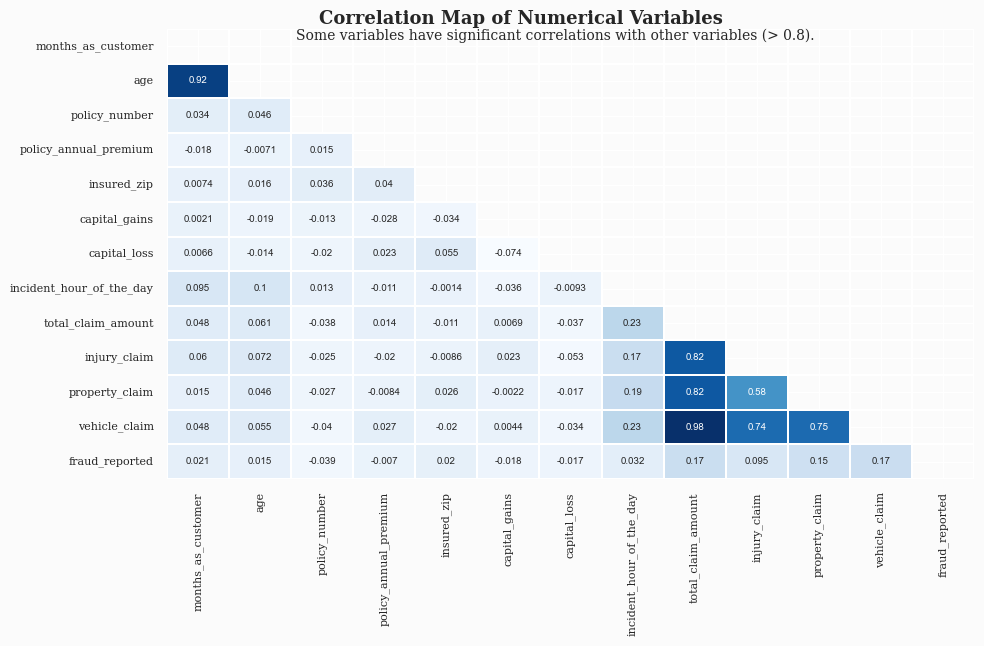

In [141]:
train_corr = train_set.copy()

train_corr.fraud_reported = train_corr.fraud_reported.map(dict(Y=1, N=0))

# -- Create Figure -- #
fig, ax = plt.subplots(figsize=(10,7))

# --- Create Correlation --- #
corr = train_corr[train_corr.select_dtypes(exclude='object').columns].corr()

# --- Create Mask --- #
mask = np.triu(np.ones_like(corr, dtype=bool))

# --- Cretea heatmap --- #
sns.heatmap(corr, annot=True, mask=mask, cmap='Blues', linewidths=0.1, cbar=False, annot_kws={"size":7})

# --- Figuration Setting --- #
yticks, ylabels = plt.yticks()
xticks, xlabels = plt.xticks()
ax.set_xticklabels(xlabels, size=8, fontfamily='serif')
ax.set_yticklabels(ylabels, size=8, fontfamily='serif')
plt.suptitle('Correlation Map of Numerical Variables', fontweight='heavy', x=0.327, y=0.96, ha='left', fontsize=13, fontfamily='serif')
plt.title('Some variables have significant correlations with other variables (> 0.8).\n', fontsize=10, x=0.16, y=0.92, fontfamily='serif', loc='left')
plt.tight_layout(rect=[0, 0.04, 1, 1.01])